In [1]:
import pandas as pd
import sqlite3
from matplotlib import pyplot as plt

# Dataset

Our dataset here is a sample of a (much) larger dataset of links posted within comments on Reddit. I derived the larger dataset   from a full data dump of Reddit (from pushshift.io). The derived links dataset is about 80 GB. The data used here is a random sample of 1,000,000 rows from the larger database.

Import the SQLite3 database as a Pandas dataframe:

In [2]:
conn = sqlite3.connect('test.db')

df = pd.read_sql_query("SELECT * FROM links", conn)

Let's take a look at the columns. We've got score, which is a measure of how upvoted something is on the site. Controversiality sounds good, but pushshift's data on that is dodgy, and likely shouldn't be used in an analysis. We also hae subreddit and the main attraction, the outbound URL pulled from the comment.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
id                  1000000 non-null int64
controversiality    1000000 non-null int64
post_id             1000000 non-null object
is_submitter        457563 non-null float64
parent_id           1000000 non-null object
permalink           415243 non-null object
score               999990 non-null float64
subreddit           1000000 non-null object
subreddit_type      400946 non-null object
created_utc         1000000 non-null int64
outbound_link       1000000 non-null object
dtypes: float64(2), int64(3), object(6)
memory usage: 83.9+ MB


Likely we want to do seomthing with some combination of the link, the timestamp, the subreddit, and/or the score.

Let's get the time field (seconds since epoch) into somethign more usable, like datetime.

In [4]:
df.created_utc

0         1136922356
1         1137149871
2         1137423371
3         1141676352
4         1143975419
5         1144255267
6         1145457598
7         1145473027
8         1146377526
9         1146746512
10        1146747844
11        1147165791
12        1147819685
13        1147958679
14        1148324568
15        1149780707
16        1151262326
17        1151570907
18        1151598405
19        1151794351
20        1152200714
21        1152832782
22        1152872326
23        1153152088
24        1153532694
25        1153977235
26        1154302446
27        1154935380
28        1155175974
29        1155751303
             ...    
999970    1569884991
999971    1569885003
999972    1569885023
999973    1569885123
999974    1569885370
999975    1569885376
999976    1569885607
999977    1569885712
999978    1569885932
999979    1569885949
999980    1569886045
999981    1569886060
999982    1569886101
999983    1569886184
999984    1569886196
999985    1569886208
999986    156

In [5]:
datetimes = pd.to_datetime(df.created_utc, unit='s')

# Add datetimes to the dataframe
# Needs 'if' statement to avoid nondeterministic state-based BS
# (Grumble grumble notebooks. They should add run-once magics or something)
if 'datetime' not in df.columns:
    df.insert(5, 'datetime', datetimes)

Let's just go ahead and make the datetimes our index. It's more useful than what we've got now.

In [6]:
df.index = df.datetime

Let's see where our sample data is distributed in time.

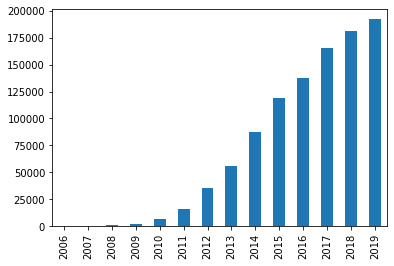

In [7]:
df.datetime.dt.year.value_counts().sort_index().plot(kind='bar')

Looks like Reddit is doing pretty well. This also validates our sampling of the larger link data set a little, as this lines up with our broad knowledge of Reddit's growth.

What are the most popular subreddits?

In [8]:
df.subreddit.value_counts().head()

AskReddit               31424
TranscribersOfReddit    29856
politics                15292
EDH                     12101
buildapc                10527
Name: subreddit, dtype: int64

The one that seems most immediately legible is r/politics. Since this is an outbound links dataset, we can answer questions like, "Which news outlets are linked in the highest scoring posts?"

Let's try answering that. First a quick validation to make sure these news outlets aren't banned or something. (Subreddits can have weird rules about linking.)

In [9]:
politics = df[df.subreddit == 'politics']
politics.outbound_link.str.contains('nytimes.com').sum()

304

We'll need a list of news outlet domains. This list is adapted from the top news domains sourced from [this site](https://www.adamsherk.com/seo/major-news-sites-ranked-by-domain-authority/). I've thrown in a few less popular but much discussed others for color.

In [10]:
# Load list of news outlets by domain rank
top_news_outlets = ['news.bbc.co.uk',
                    'economist.com',
                    'nytimes.com',
                    'msnbc.msn.com',
                    'cnn.com',
                    'abcnews.go.com',
                    'wsj.com',
                    'time.com',
                    'usatoday.com',
                    'washingtonpost.com',
                    'forbes.com',
                    'guardian.co.uk',
                    'latimes.com',
                    'timesonline.co.uk',
                    'foxnews.com',
                    'telegraph.co.uk',
                    'huffingtonpost.com',
                    'npr.org',
                    'cbsnews.com',
                    'csmonitor.com',
                    'breitbart.com',
                    'aljazeera.com']


Now we'll derive a new dataframe with only links that contain the above domain and TLD.

In [11]:
links_data =  []

for outlet in top_news_outlets:
    subset_df = df[df.outbound_link.str.contains(outlet)]
    subset_df = subset_df[['datetime', 'score']]
    subset_df['outlet'] = outlet
    links_data.append(subset_df)



In [12]:
outlets_df = pd.concat(links_data)

outlets_df

,datetime,score,outlet
datetime,,,
2006-09-17 13:36:47,2006-09-17 13:36:47,-1.0,news.bbc.co.uk
2006-11-24 17:02:54,2006-11-24 17:02:54,11.0,news.bbc.co.uk
2007-06-21 17:32:44,2007-06-21 17:32:44,12.0,news.bbc.co.uk
2007-12-11 07:24:02,2007-12-11 07:24:02,5.0,news.bbc.co.uk
2008-03-13 02:50:04,2008-03-13 02:50:04,2.0,news.bbc.co.uk
2008-10-13 22:32:06,2008-10-13 22:32:06,1.0,news.bbc.co.uk
2009-01-12 18:34:10,2009-01-12 18:34:10,1.0,news.bbc.co.uk
2009-01-16 16:40:11,2009-01-16 16:40:11,1.0,news.bbc.co.uk
2009-02-06 19:44:19,2009-02-06 19:44:19,2.0,news.bbc.co.uk


To visualize that we'll need to resamplle and sum by month.

In [13]:
outlets_by_score = outlets_df.groupby('outlet').sum().sort_values(by='score', ascending=False)

outlets_by_score

,score
outlet,
nytimes.com,41164.0
time.com,34796.0
washingtonpost.com,33630.0
cnn.com,21487.0
telegraph.co.uk,8047.0
npr.org,5077.0
cbsnews.com,4692.0
usatoday.com,4686.0
latimes.com,3991.0


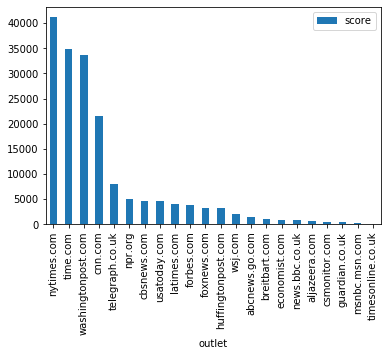

In [14]:
outlets_by_score.plot(kind='bar')

Pretty clear winner-take-all credibility dynamic here, assuming score can be used as a proxy for credibility. I'm curious about 2016, though. As an election year, would this ranking look much different?

In [15]:
outlets_df_2016 = outlets_df[outlets_df.datetime.dt.year == 2016]
outlets_by_score_2016 = outlets_df_2016.groupby('outlet').sum().sort_values(by='score', ascending=False)
outlets_by_score_2016

,score
outlet,
nytimes.com,2815.0
cnn.com,1860.0
latimes.com,1778.0
washingtonpost.com,1105.0
forbes.com,703.0
npr.org,586.0
huffingtonpost.com,525.0
telegraph.co.uk,355.0
time.com,309.0


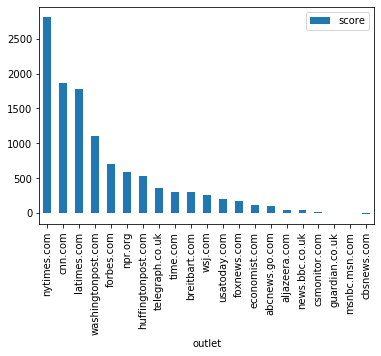

In [16]:
outlets_by_score_2016.plot(kind='bar')

Breitbart might not seem huge on the graph, but look at the company it's keeping, a tick above the WSJ, and it's in the top 10.

It would be interesting to look not just at the sum, but mean and median scores linking to these outlets. The links dataset can support a variety of inquiries, and seems especially suited to network visualizations. Alternatively, one could start with a link, such as a viral video or news story, and see where and when it surfaces on Reddit.